# Image classification 

Mahmoud Khorshed



# Function build model

In [ ]:
def build_model(num_classes):
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = True

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model
NUM_CLASSES = 8

model = build_model(num_classes=NUM_CLASSES)

epochs = 25  # @param {type: "slider", min:8, max:80}
hist = model.fit(x=x_train_image_norm,
                 y=y_train_label,
                 epochs=epochs,
                 validation_data=0.2, verbose=1)
plot_hist(hist)

# 1- **import libraries and Data**

In [204]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # statistical data visualization
sns.set()
import math   
import matplotlib.pyplot as plt # data visualization
%matplotlib inline
import glob
import itertools
import cv2
import random

from time import time
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold,train_test_split,cross_val_score,cross_val_predict
from sklearn.metrics import classification_report,f1_score ,roc_auc_score,accuracy_score

#Grid Search
from sklearn.preprocessing import StandardScaler , OneHotEncoder

#Tensor flow
from keras import backend as K 




import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Conv2D, Flatten, MaxPool2D ,LayerNormalization,BatchNormalization,Rescaling
from tensorflow.keras.layers import Dropout,LSTM,Reshape,SpatialDropout1D,Bidirectional,TimeDistributed
from tensorflow.keras.optimizers import Adam , RMSprop,Nadam
from tensorflow.keras.utils import plot_model
from tensorflow.keras import layers
#importing the required libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPool2D

import tensorflow_hub as hub

#IMAGES 
from tqdm.notebook import tqdm
from PIL import Image
import os
from ast import literal_eval

# some seeting for pandas and hvplot

pd.options.display.max_columns = 100
pd.options.display.max_rows = 300
pd.options.display.max_colwidth = 100
np.set_printoptions(threshold=2000)

# import cv2
import os
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread


import warnings
warnings.filterwarnings('ignore')


In [ ]:
# !pip install pandas-profiling

# 1- Prepare and read data 

## Make data Frame contains Images names and Labels

In [2]:
def Load_images_to_DataFrame(Folder_Path = 'train/*'):
    Classess = glob.glob(f"{Folder_Path}")
    print('\n',Classess)
    Images = []
    for i in Classess:
        images = glob.glob(f"{i}/*")
        Images.append(images)
    new_Images = list(itertools.chain(*Images))
    new_Images_arr = res = np.array(new_Images)
    Data_Images = pd.DataFrame(new_Images_arr)
    Data_Images.rename(columns = {0:'Images'}, inplace = True)
    Data_Images['Label'] = Data_Images['Images'].str.split('\\', 2, expand=True)[1]
    print('\n',Data_Images.sample(1))
    
    return Data_Images

In [3]:
train_images = Load_images_to_DataFrame(Folder_Path = 'train/*')
test_images = Load_images_to_DataFrame(Folder_Path = 'test/*')


 ['train\\bus', 'train\\crossover', 'train\\hatchback', 'train\\motorcycle', 'train\\pickup-truck', 'train\\sedan', 'train\\truck', 'train\\van']

                                  Images  Label
2874  train\sedan\sedan-front (786).jpg  sedan

 ['test\\bus', 'test\\crossover', 'test\\hatchback', 'test\\motorcycle', 'test\\pickup-truck', 'test\\sedan', 'test\\truck', 'test\\van']

                                      Images      Label
92  test\crossover\crossover-back (244).jpg  crossover


In [4]:
train_images.sample(5)

Images      Label
1592          train\sedan\sedan-back (2006).jpg      sedan
2373         train\sedan\sedan-front (1754).jpg      sedan
866   train\hatchback\hatchback-front (280).jpg  hatchback
3486              train\van\van-front (174).jpg        van
1510          train\sedan\sedan-back (1673).jpg      sedan

# 2- **Exploratory Data**  

## Display Images

In [5]:
def load_images_to_Data_frame(Image_Path=None,Number_Photos=3):
    images= list(Image_Path)
    
    for k in range(Number_Photos):
        fig = plt.figure(figsize=(15,10))
        Add=fig.add_subplot(math.ceil(Number_Photos/2),math.ceil(Number_Photos/2),k+1)
        image = Image.open(images[k])
        imshow(image,cmap='Greys_r',aspect="equal")
        axis('off')        
    
    return images



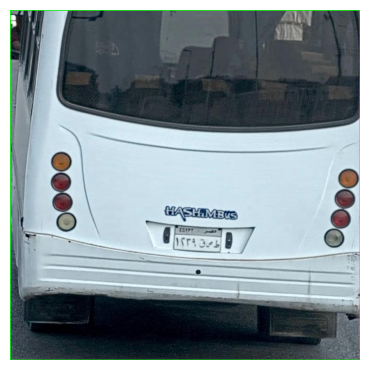

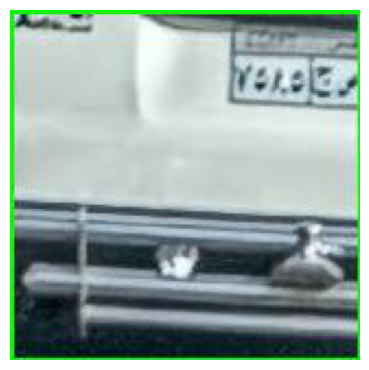

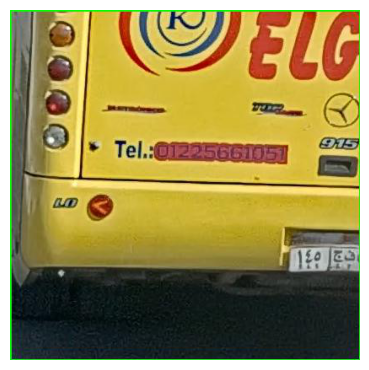

In [6]:
images_train = load_images_to_Data_frame(Image_Path=train_images['Images'],Number_Photos=3)

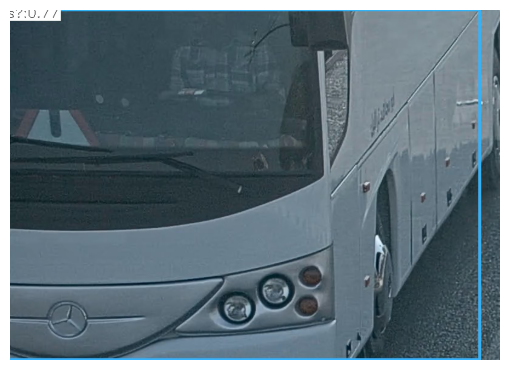

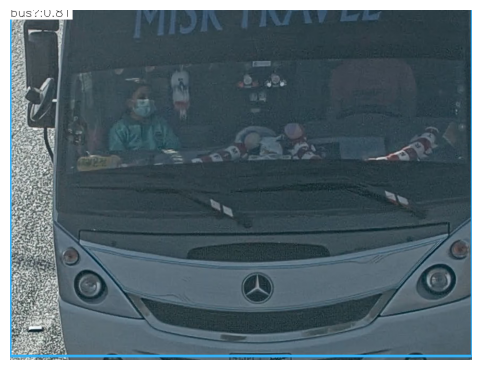

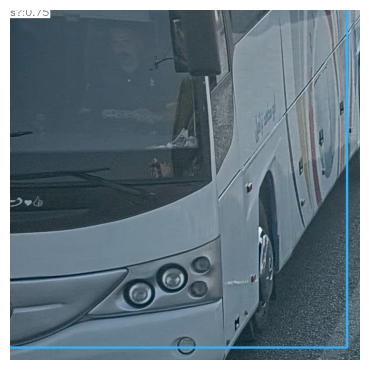

In [7]:
images_test = load_images_to_Data_frame(Image_Path=test_images['Images'],Number_Photos=3)

In [8]:
%%time
from pandas_profiling import ProfileReport

profile_train = ProfileReport(train_images, title="Pandas Profiling Report")
profile_train.to_widgets()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

CPU times: total: 3.48 s
Wall time: 3.69 s


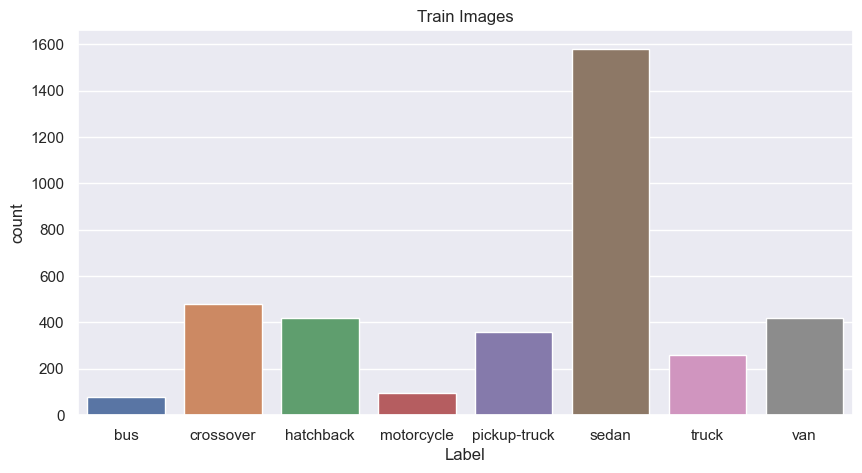

In [9]:
#Count plot match
plt.figure(figsize=(10,5))
ax = sns.countplot(x="Label", data=train_images)
plt.title('Train Images')

plt.show()

In [10]:
profile_test = ProfileReport(test_images, title="Pandas Profiling Report")
profile_test.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

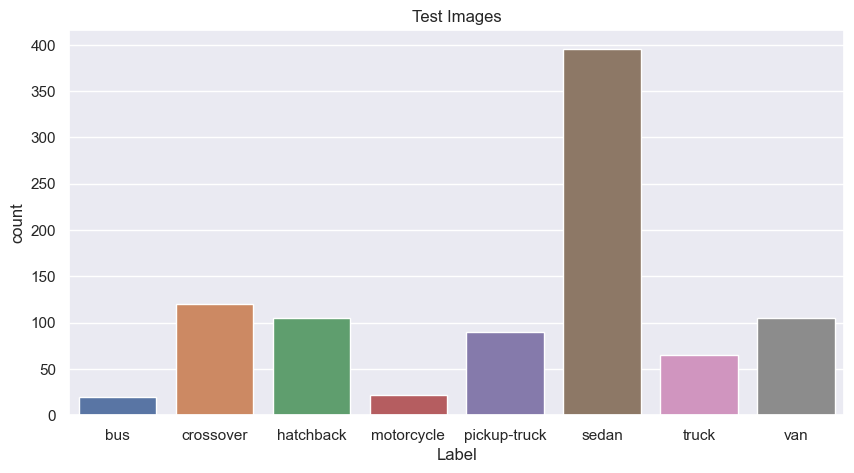

In [11]:
#Count plot match
plt.figure(figsize=(10,5))
ax = sns.countplot(x="Label", data=test_images)
plt.title('Test Images')
plt.show()

### Some insights 

- The data is uniform distributed

- The Data has un balanced classed  (**Sedan** is more than other classes)

- No missing or duplicated in data 

- Data has 8 classes 

# 3- **Train Preprocessing**

**Stage1** Convert labels dtypes

**Stage2** DownSampling Data 

**Stage3** Extract features from images

**Stage4** Normalizing Images

**Stage5** Data Augmentation



## 1- Convert labels dtypes

In [12]:
# y_train_label = train_images['Label'].astype('category').cat.codes
# y_test_label = test_images['Label'].astype('category').cat.codes

train_images['Label'] = train_images['Label'].astype('category')
d = dict(enumerate(train_images['Label'].cat.categories))
# Then map backwards:
train_images['labels_codes'] = train_images['Label'].cat.codes
# train_images['labels_codes_reversed'] = train_images['labels_codes'].map(d)

y_train_label = train_images['labels_codes']


In [13]:
y_train_label.shape

(3685,)

In [14]:
train_images.sample(5)

Images       Label  labels_codes
2348           train\sedan\sedan-front (1718).jpg       sedan             5
2596            train\sedan\sedan-front (364).jpg       sedan             5
1058  train\motorcycle\1_BICYCLE_17-04-40-834.jpg  motorcycle             3
3050               train\truck\truck-back (4).jpg       truck             6
940      train\hatchback\hatchback-front (44).jpg   hatchback             2

In [15]:
test_images['Label'] = test_images['Label'].astype('category')
d = dict(enumerate(test_images['Label'].cat.categories))
# Then map backwards:
test_images['labels_codes'] = test_images['Label'].cat.codes
y_test_label = test_images['labels_codes']
# test_images['labels_codes_reversed'] = test_images['labels_codes'].map(d)

In [16]:
test_images.sample(5)

Images         Label  labels_codes
816         test\truck\truck-front (38).jpg         truck             6
133  test\crossover\crossover-back (81).jpg     crossover             1
301  test\pickup-truck\pickup-back (26).jpg  pickup-truck             4
905             test\van\van-front (43).jpg           van             7
846             test\van\van-back (163).jpg           van             7

# 2- Data Down Sampling

In [83]:
#Train
train_images_DS = train_images.drop(train_images[train_images['Label'] == 'sedan'].sample(int(train_images[train_images['Label'] == 'sedan'].shape[0]*0.7)).index)
train_images_DS.reset_index(inplace = True)
train_images_DS.drop(columns=['index'],inplace = True)
print(train_images_DS.shape)
train_images_DS['Label'].value_counts()


(2579, 3)


crossover       480
sedan           475
hatchback       419
van             418
pickup-truck    357
truck           258
motorcycle       95
bus              77
Name: Label, dtype: int64

In [84]:
y_train_label = train_images_DS['labels_codes']

In [85]:
train_images_DS[train_images_DS.index ==1945 ]

Images  Label  labels_codes
1945  train\truck\truck-back (40).jpg  truck             6

In [86]:
train_images_DS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2579 entries, 0 to 2578
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Images        2579 non-null   object  
 1   Label         2579 non-null   category
 2   labels_codes  2579 non-null   int8    
dtypes: category(1), int8(1), object(1)
memory usage: 25.7+ KB


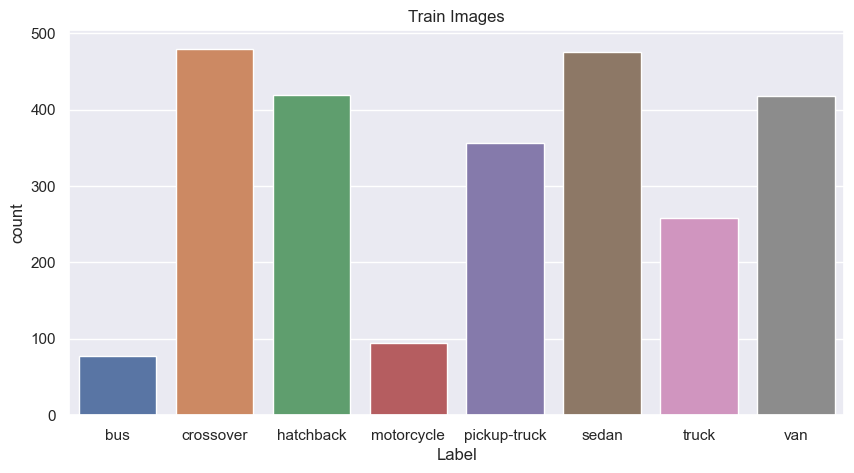

In [87]:
#Count plot match
plt.figure(figsize=(10,5))
ax = sns.countplot(x="Label", data=train_images_DS)
plt.title('Train Images')

plt.show()

In [22]:
#Train
test_images_DS = test_images.drop(test_images[test_images['Label'] == 'sedan'].sample(int(test_images[test_images['Label'] == 'sedan'].shape[0]*0.7)).index)
test_images_DS.reset_index(inplace=True)
test_images_DS.drop(columns=['index'],inplace = True)

print(test_images_DS.shape)
test_images_DS['Label'].value_counts()


(646, 3)


crossover       120
sedan           119
hatchback       105
van             105
pickup-truck     90
truck            65
motorcycle       22
bus              20
Name: Label, dtype: int64

In [23]:
y_test_label = test_images_DS['labels_codes']

In [24]:
test_images_DS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Images        646 non-null    object  
 1   Label         646 non-null    category
 2   labels_codes  646 non-null    int8    
dtypes: category(1), int8(1), object(1)
memory usage: 6.8+ KB


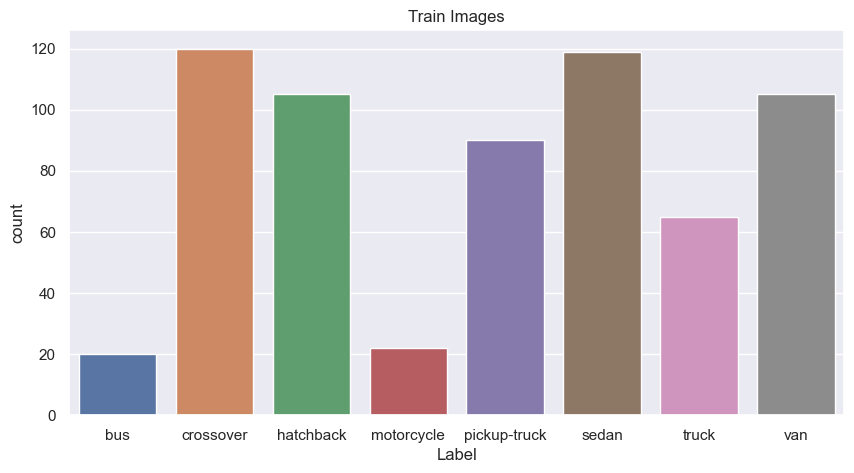

In [25]:
#Count plot match
plt.figure(figsize=(10,5))
ax = sns.countplot(x="Label", data=test_images_DS)
plt.title('Train Images')

plt.show()

## 3- Load and Resize images 

In [88]:
width,height = 224,224
def load_image(path):
    
#   image = Image.open(path).convert('LA').resize(( width,height,3))   #2 Channels
    image = cv2.imread(path)   #3 Channels 
    arr = np.array(image)
    arr = tf.image.resize(image, tf.constant([width,height]))
                          
    return arr

In [89]:
%%time
from tqdm.notebook import tqdm
x_train_image = np.array([load_image(i) for i in tqdm(train_images_DS['Images'])])

x_test_image = np.array([load_image(i) for i in tqdm(test_images_DS['Images'])])



  0%|          | 0/2579 [00:00<?, ?it/s]

  0%|          | 0/646 [00:00<?, ?it/s]

CPU times: total: 12.2 s
Wall time: 13.3 s


In [90]:
x_train_image.shape

(2579, 224, 224, 3)

In [91]:
x_train_image[6].shape

(224, 224, 3)

In [92]:
# 1435 1945

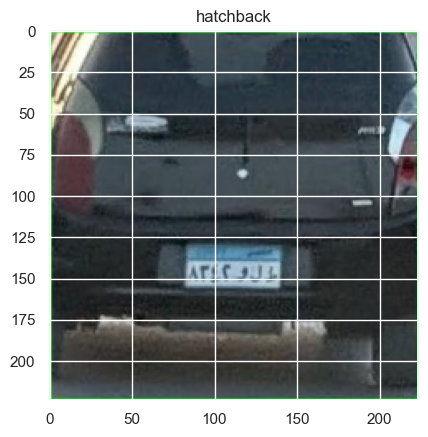

In [93]:
# check image loading

img_num = np.random.randint(1, x_train_image.shape[0])

plt.imshow(cv2.cvtColor(x_train_image[img_num],cv2.COLOR_BGR2RGB).astype(int))
plt.title(train_images_DS['Label'][img_num]);

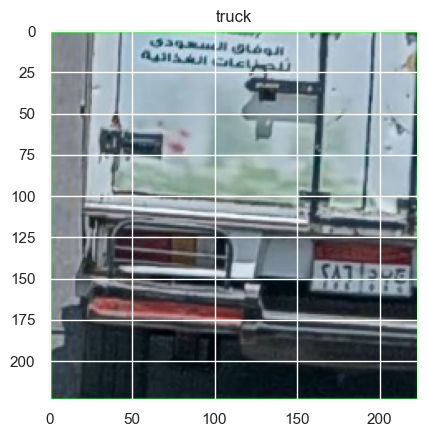

In [94]:
# check image loading
img_num = np.random.randint(1, x_test_image.shape[0])

plt.imshow(cv2.cvtColor(x_test_image[img_num],cv2.COLOR_BGR2RGB).astype(int));
plt.title(test_images_DS['Label'][img_num]);

## 4-  Normalizing Images 

In [95]:
# Rescaling using tensorflow
x_train_image_norm = Rescaling(1./255)(x_train_image)
x_test_image_norm = Rescaling(1./255)(x_test_image)


In [96]:
print('Shape X train = ',x_train_image_norm.shape,'and Shape X test = ',x_test_image_norm.shape)

Shape X train =  (2579, 224, 224, 3) and Shape X test =  (646, 224, 224, 3)


In [97]:
print("Min and max pixel values:", x_train_image_norm.numpy().min(), x_train_image_norm.numpy().max())


Min and max pixel values: 0.0 1.0


In [98]:
x_train_image_norm[0]

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.16291451, 0.8588477 , 0.161588  ],
        [0.25443473, 0.7727291 , 0.227451  ],
        [0.25324452, 0.7652749 , 0.22919863],
        ...,
        [0.09991207, 0.6071252 , 0.08293931],
        [0.13509873, 0.6424438 , 0.11408989],
        [0.18847984, 0.72770077, 0.16106388]],

       [[0.23931412, 0.7772409 , 0.20333555],
        [0.5498675 , 0.5607469 , 0.47420225],
        [0.6244205 , 0.5212282 , 0.54146445],
        ...,
        [0.16259733, 0.13374566, 0.07947434],
        [0.2687314 , 0.23008205, 0.18717644],
        [0.31904432, 0.41010728, 0.24015778]],

       [[0.1681148 , 0.7038199 , 0.14690769],
        [0.40903407, 0.33780906, 0.35264447],
        [0.35376385, 0.34377185, 0.31418493],
        ...,
        [0.18464912, 0.15327658, 0.11117224],
        [0.26921248, 0.2361426 , 0.19403829],
        [0.28273177, 0.4188915 , 0.23151281]],

       ...,

       [[0.16012847, 0.6544212 , 0.13229233],
        [0.42

## 5- Data augmentation 

In [120]:
K.clear_session() #Restart seed = 0

data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.05),# tyr 0.2 but not logic
    layers.RandomZoom(0.1),
#     layers.RandomContrast(factor=0.1),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
])



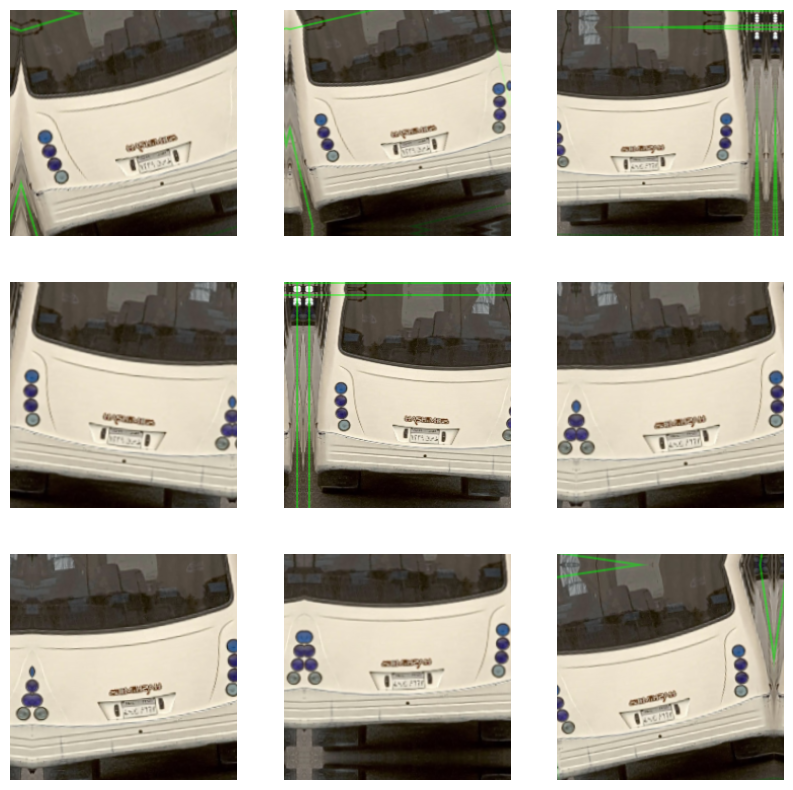

In [121]:
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(x_train_image_norm)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")

# 4- Model

In [111]:
len_Label = train_images['Label'].nunique()
len_Label

8

## 1- The Art of Transfer Learning
## 1.1 MobileNetV2

## Download and explore the dataset

In [236]:
data_dir = 'train'
test_data_dir = 'test'

Define some parameters for the loader:

In [237]:
IMAGE_SHAPE = (224, 224)
batch_size = 32
img_height = 224
img_width = 224

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [238]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3685 files belonging to 8 classes.
Using 2948 files for training.


In [239]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3685 files belonging to 8 classes.
Using 737 files for validation.


In [240]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  test_data_dir,
#   validation_split=0.2,
#   subset="test",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 923 files belonging to 8 classes.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [241]:
class_names = train_ds.class_names
print(class_names)

['bus', 'crossover', 'hatchback', 'motorcycle', 'pickup-truck', 'sedan', 'truck', 'van']


## Visualize the data

Here are the first nine images from the training dataset:

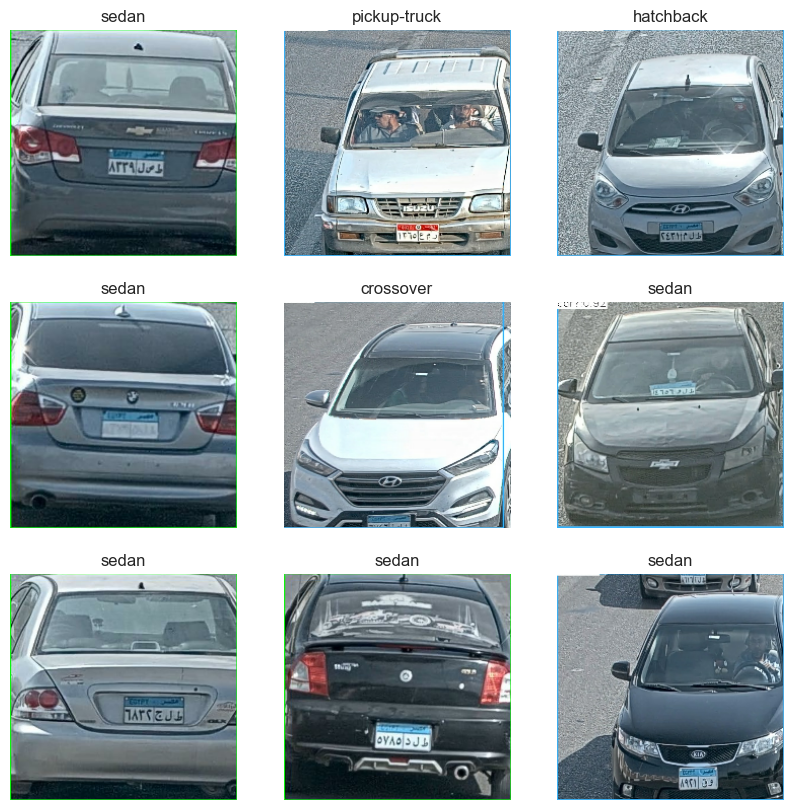

In [242]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [243]:
for image_batch, labels_batch in train_ds:
      print(image_batch.shape)
      print(labels_batch.shape)
      break
num_classes = len(class_names)

(32, 224, 224, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 224, 224, 3)`. This is a batch of 32 images of shape `224x224x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [244]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

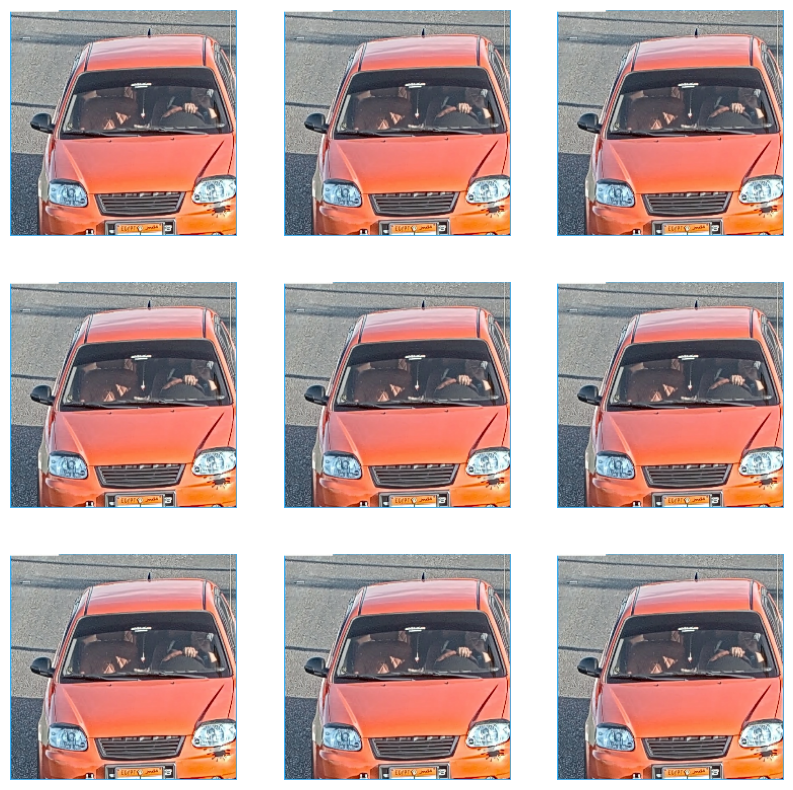

In [245]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [246]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [247]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [248]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## adding Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

## 2- transfer learning mobilenet_v2 - inception_v3 -effienect


### 2.1 mobilenet_v2

In [ ]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

In [205]:

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])


In [208]:
feature_extractor_layer = hub.KerasLayer(
    classifier_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [209]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1001)


In [ ]:
num_classes = len(class_names)
K.clear_session() #Restart seed = 0

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

In [214]:
import datetime
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [215]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

Epoch 1/10
93/93 [==============================] - 39s 356ms/step - loss: 1.4288 - acc: 0.5007 - val_loss: 1.1809 - val_acc: 0.5834
Epoch 2/10
93/93 [==============================] - 31s 339ms/step - loss: 1.0955 - acc: 0.6085 - val_loss: 1.1126 - val_acc: 0.5848
Epoch 3/10
93/93 [==============================] - 31s 329ms/step - loss: 0.9758 - acc: 0.6445 - val_loss: 0.9924 - val_acc: 0.6730
Epoch 4/10
93/93 [==============================] - 31s 332ms/step - loss: 0.8997 - acc: 0.6754 - val_loss: 0.9474 - val_acc: 0.6811
Epoch 5/10
93/93 [==============================] - 32s 341ms/step - loss: 0.8502 - acc: 0.6991 - val_loss: 0.9648 - val_acc: 0.6689
Epoch 6/10
93/93 [==============================] - 31s 332ms/step - loss: 0.8489 - acc: 0.6957 - val_loss: 0.9040 - val_acc: 0.6906
Epoch 7/10
93/93 [==============================] - 31s 331ms/step - loss: 0.7904 - acc: 0.7215 - val_loss: 0.8814 - val_acc: 0.7191
Epoch 8/10
93/93 [==============================] - 31s 337ms/step - 

## Evalution

###  Plot Performance

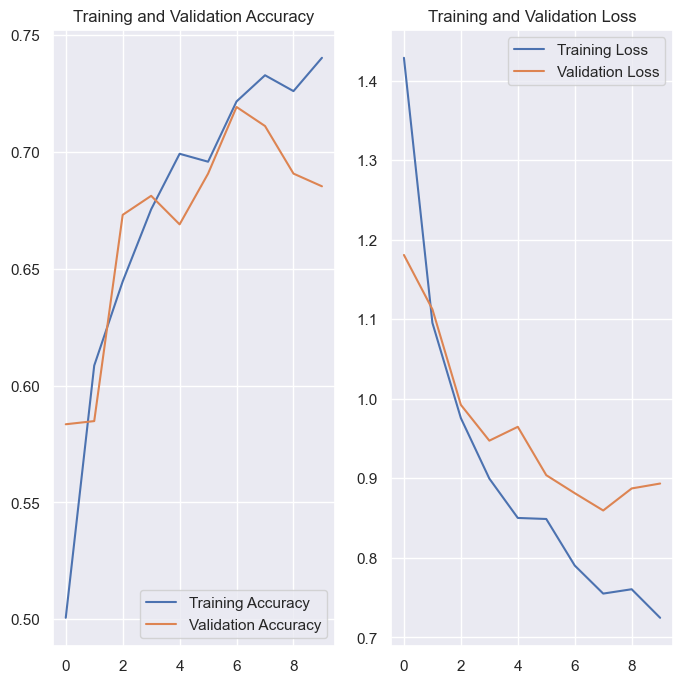

In [216]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [217]:
test_loss = model.evaluate(test_images,test_labels)

29/29 [==============================] - 8s 270ms/step - loss: 3.2811 - acc: 0.2004


In [218]:
len(test_images)

923

In [219]:
test_images

array([[[[0.9960785 , 0.9960785 , 0.9960785 ],
         [1.        , 1.        , 1.        ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         ...,
         [0.5019608 , 0.5686275 , 0.6       ],
         [0.50980395, 0.5764706 , 0.60784316],
         [0.5137255 , 0.5803922 , 0.6117647 ]],

        [[0.9960785 , 0.9960785 , 0.9960785 ],
         [0.08627451, 0.08627451, 0.08627451],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         ...,
         [0.5058824 , 0.57254905, 0.6039216 ],
         [0.5058824 , 0.57254905, 0.6039216 ],
         [0.4901961 , 0.5568628 , 0.5882353 ]],

        [[0.34117648, 0.34117648, 0.34117648],
         [1.        , 1.        , 1.        ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         ...,
         [0.5058824 , 0.57254905, 0.6039216 ],
         [0.5019608 , 0.5686275 , 0.6       ],
         [0.49411768, 0.5568628 , 0.5882353 ]],

        ...,

        [[0.3372549 , 0.42352945, 0.47450984],
         [0.2901961 , 0.37647063, 0.427451  ]

In [220]:
y_hat = model.predict(test_images)
pred_lables = np.argmax(y_hat,axis = 1)

29/29 [==============================] - 8s 257ms/step


In [221]:
print(classification_report(test_labels,pred_lables))

              precision    recall  f1-score   support

           0       0.01      0.05      0.02        20
           1       0.15      0.48      0.23       120
           2       0.00      0.00      0.00       105
           3       0.67      0.55      0.60        22
           4       0.27      0.13      0.18        90
           5       0.32      0.12      0.17       396
           6       0.40      0.38      0.39        65
           7       0.19      0.30      0.23       105

    accuracy                           0.20       923
   macro avg       0.25      0.25      0.23       923
weighted avg       0.25      0.20      0.19       923



In [222]:
new_dict = {value:key for (key,value) in class_name_label.items()}
new_dict

{0: 'bus',
 1: 'crossover',
 2: 'hatchback',
 3: 'motorcycle',
 4: 'pickup-truck',
 5: 'sedan',
 6: 'truck',
 7: 'van'}

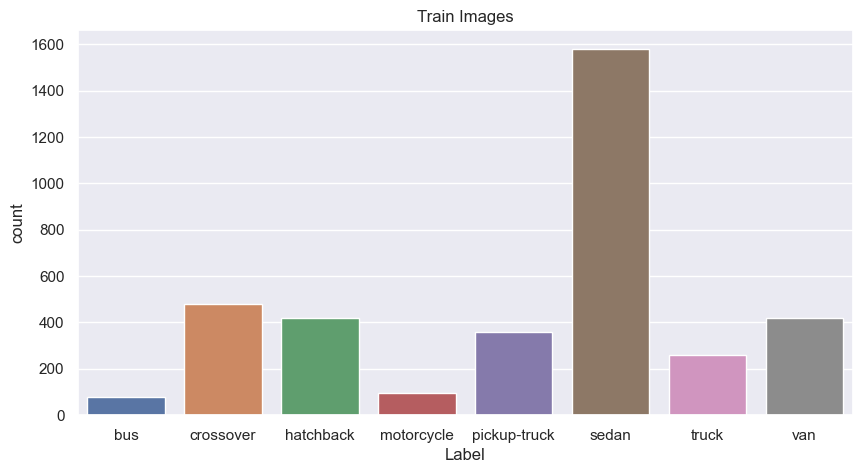

In [223]:
new_dict.values()

dict_values(['bus', 'crossover', 'hatchback', 'motorcycle', 'pickup-truck', 'sedan', 'truck', 'van'])

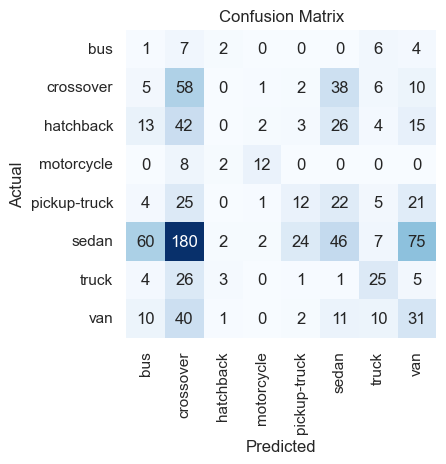

In [228]:
classes = 8
length=classes

x_axis_labels = new_dict.values() # labels for x-axis
y_axis_labels = new_dict.values() # labels for y-axis


fig_width= int(length * .5)
fig_height= int(length * .5)

cm = confusion_matrix(test_labels,pred_lables )
plt.figure(figsize=(fig_width, fig_height))
 
sns.heatmap(cm, annot=True,xticklabels=class_names, yticklabels=class_names, vmin=0, fmt='g', cmap='Blues', cbar=False)       

# plt.xticks(np.arange(length)+.5, classes, rotation= 90)

# plt.yticks(np.arange(length)+.5, classes, rotation=0)

plt.xlabel("Predicted")

plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

## Save Model

In [229]:
from tensorflow.keras.models import load_model

In [230]:
model.save(os.path.join('models','MobileNet_.h5'))

In [231]:
new_model = load_model(os.path.join('models','Cars_CNN.h5'))

In [232]:
new_model

In [233]:
img_path = 'D:\Work\AIactive\sedan.jpg'  # image online
#open and resize img
image = cv2.imread(img_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image,Image_size)
image = Rescaling(1./255)(image)        
image_test = np.array(image,dtype='float32')
print(image_test.shape)
y_hat_t = new_model.predict(np.expand_dims(image_test,0))
print(y_hat_t)
pred_lables = np.argmax(y_hat_t,axis = 1)
classes = list(new_dict.values())
print('pred_lables',pred_lables,'is',classes[pred_lables[0]])
# print(classes[pred_lables[0]])


(224, 224, 3)
1/1 [==============================] - 0s 84ms/step
[[1.3056308e-02 1.4749880e-11 2.0755076e-07 4.7859654e-08 1.2302092e-01
  8.6347806e-01 2.1486452e-05 4.2301792e-04]]
pred_lables [5] is sedan


### 2.2 inception_v3

In [256]:
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = inception_v3

In [257]:
# K.clear_session() #Restart seed = 0

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])


KeyboardInterrupt: 

In [ ]:
feature_extractor_layer = hub.KerasLayer(
    classifier,
    input_shape=(224, 224, 3),
    trainable=False)

In [ ]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

In [ ]:
num_classes = len(class_names)
K.clear_session() #Restart seed = 0

model = tf.keras.Sequential([
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])

model.summary()

In [ ]:
predictions = model(image_batch)

In [ ]:
predictions.shape

In [ ]:
import datetime
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

In [ ]:
NUM_EPOCHS = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS,
                    callbacks=tensorboard_callback)

In [ ]:
%load_ext tensorboard

%tensorboard --logdir logs/fit

# 2.3 eff_net


In [258]:
from tensorflow.keras.applications import EfficientNetB0
model = EfficientNetB0(weights='imagenet')

In [259]:
model = EfficientNetB0(include_top=False, weights='imagenet')

In [260]:
NUM_CLASSES = 8

In [263]:
def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    x = data_augmentation(inputs)
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [270]:
# model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_4 (Sequential)      (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['sequential_4[1][0]']           
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']   

                                                                  'block2a_se_expand[0][0]']      
                                                                                                  
 block2a_project_conv (Conv2D)  (None, 56, 56, 24)   2304        ['block2a_se_excite[0][0]']      
                                                                                                  
 block2a_project_bn (BatchNorma  (None, 56, 56, 24)  96          ['block2a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block2b_expand_conv (Conv2D)   (None, 56, 56, 144)  3456        ['block2a_project_bn[0][0]']     
                                                                                                  
 block2b_expand_bn (BatchNormal  (None, 56, 56, 144)  576        ['block2b_expand_conv[0][0]']    
 ization) 

 block3b_expand_conv (Conv2D)   (None, 28, 28, 240)  9600        ['block3a_project_bn[0][0]']     
                                                                                                  
 block3b_expand_bn (BatchNormal  (None, 28, 28, 240)  960        ['block3b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block3b_expand_activation (Act  (None, 28, 28, 240)  0          ['block3b_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block3b_dwconv (DepthwiseConv2  (None, 28, 28, 240)  6000       ['block3b_expand_activation[0][0]
 D)                                                              ']                               
          

                                                                                                  
 block4b_dwconv (DepthwiseConv2  (None, 14, 14, 480)  4320       ['block4b_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block4b_bn (BatchNormalization  (None, 14, 14, 480)  1920       ['block4b_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4b_activation (Activation  (None, 14, 14, 480)  0          ['block4b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4b_s

 )                                                                                                
                                                                                                  
 block5a_activation (Activation  (None, 14, 14, 480)  0          ['block5a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5a_se_squeeze (GlobalAver  (None, 480)         0           ['block5a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block5a_se_reshape (Reshape)   (None, 1, 1, 480)    0           ['block5a_se_squeeze[0][0]']     
                                                                                                  
 block5a_s

 block5c_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block5c_se_reshape[0][0]']     
                                                                                                  
 block5c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block5c_se_reduce[0][0]']      
                                                                                                  
 block5c_se_excite (Multiply)   (None, 14, 14, 672)  0           ['block5c_activation[0][0]',     
                                                                  'block5c_se_expand[0][0]']      
                                                                                                  
 block5c_project_conv (Conv2D)  (None, 14, 14, 112)  75264       ['block5c_se_excite[0][0]']      
                                                                                                  
 block5c_project_bn (BatchNorma  (None, 14, 14, 112)  448        ['block5c_project_conv[0][0]']   
 lization)

 block6b_project_conv (Conv2D)  (None, 7, 7, 192)    221184      ['block6b_se_excite[0][0]']      
                                                                                                  
 block6b_project_bn (BatchNorma  (None, 7, 7, 192)   768         ['block6b_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block6b_drop (Dropout)         (None, 7, 7, 192)    0           ['block6b_project_bn[0][0]']     
                                                                                                  
 block6b_add (Add)              (None, 7, 7, 192)    0           ['block6b_drop[0][0]',           
                                                                  'block6a_project_bn[0][0]']     
                                                                                                  
 block6c_e

 block6d_drop (Dropout)         (None, 7, 7, 192)    0           ['block6d_project_bn[0][0]']     
                                                                                                  
 block6d_add (Add)              (None, 7, 7, 192)    0           ['block6d_drop[0][0]',           
                                                                  'block6c_add[0][0]']            
                                                                                                  
 block7a_expand_conv (Conv2D)   (None, 7, 7, 1152)   221184      ['block6d_add[0][0]']            
                                                                                                  
 block7a_expand_bn (BatchNormal  (None, 7, 7, 1152)  4608        ['block7a_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block7a_e

In [ ]:
K.clear_session() #Restart seed = 0
model = build_model(num_classes=8)
model.summary()


In [264]:
epochs = 10  # @param {type: "slider", min:8, max:80}
hist = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=tensorboard_callback)


Epoch 1/10


93/93 [==============================] - 70s 645ms/step - loss: 1.2212 - accuracy: 0.7093 - val_loss: 1.0119 - val_accuracy: 0.6635
Epoch 2/10
93/93 [==============================] - 58s 620ms/step - loss: 0.9597 - accuracy: 0.7975 - val_loss: 0.9164 - val_accuracy: 0.7585
Epoch 3/10
93/93 [==============================] - 58s 621ms/step - loss: 0.9047 - accuracy: 0.7931 - val_loss: 0.5687 - val_accuracy: 0.8331
Epoch 4/10
93/93 [==============================] - 58s 627ms/step - loss: 0.8722 - accuracy: 0.8090 - val_loss: 0.8173 - val_accuracy: 0.8263
Epoch 5/10
93/93 [==============================] - 57s 616ms/step - loss: 0.7590 - accuracy: 0.8239 - val_loss: 0.7579 - val_accuracy: 0.8304
Epoch 6/10
93/93 [==============================] - 57s 615ms/step - loss: 0.7999 - accuracy: 0.8145 - val_loss: 0.7058 - val_accuracy: 0.8535
Epoch 7/10
93/93 [==============================] - 56s 603ms/step - loss: 0.7435 - accuracy: 0.8212 - val_loss: 0.6105 - val_accuracy: 0.8535
Epoch 8/10

In [265]:
%load_ext tensorboard

%tensorboard --logdir logs/fit

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

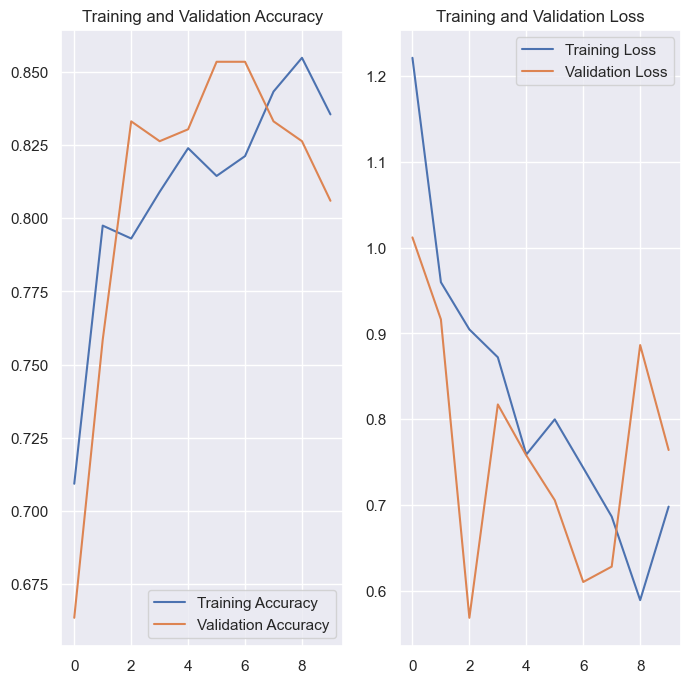

In [274]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [268]:
img_path = 'D:\Work\AIactive\sedan.jpg'  # image online
#open and resize img
image = cv2.imread(img_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image,Image_size)
image = Rescaling(1./255)(image)        
image_test = np.array(image,dtype='float32')
print(image_test.shape)
y_hat_t = model.predict(np.expand_dims(image_test,0))
print(y_hat_t)
pred_lables = np.argmax(y_hat_t,axis = 1)
classes = list(new_dict.values())
print('pred_lables',pred_lables,'is',classes[pred_lables[0]])
# print(classes[pred_lables[0]])


(224, 224, 3)
1/1 [==============================] - 0s 33ms/step
[[1.4821608e-08 9.9179780e-01 6.3249114e-04 2.4449918e-04 7.3086447e-03
  1.6543003e-05 4.0534033e-08 7.2956139e-09]]
pred_lables [1] is crossover


29/29 [==============================] - 14s 470ms/step


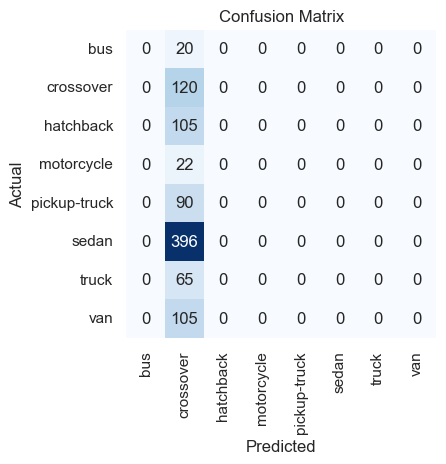

In [269]:
classes = 8
length=classes

y_hat = model.predict(test_images)
pred_lables = np.argmax(y_hat,axis = 1)

x_axis_labels = new_dict.values() # labels for x-axis
y_axis_labels = new_dict.values() # labels for y-axis


fig_width= int(length * .5)
fig_height= int(length * .5)

cm = confusion_matrix(test_labels,pred_lables )
plt.figure(figsize=(fig_width, fig_height))
 
sns.heatmap(cm, annot=True,xticklabels=class_names, yticklabels=class_names, vmin=0, fmt='g', cmap='Blues', cbar=False)       

# plt.xticks(np.arange(length)+.5, classes, rotation= 90)

# plt.yticks(np.arange(length)+.5, classes, rotation=0)

plt.xlabel("Predicted")

plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

In [271]:
print(classification_report(test_labels,pred_lables))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.13      1.00      0.23       120
           2       0.00      0.00      0.00       105
           3       0.00      0.00      0.00        22
           4       0.00      0.00      0.00        90
           5       0.00      0.00      0.00       396
           6       0.00      0.00      0.00        65
           7       0.00      0.00      0.00       105

    accuracy                           0.13       923
   macro avg       0.02      0.12      0.03       923
weighted avg       0.02      0.13      0.03       923



## Save Model

In [229]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','EffienctNet_.h5'))

In [231]:
new_model = load_model(os.path.join('models','EffienctNet_.h5'))

In [232]:
new_model

In [233]:
img_path = 'D:\Work\AIactive\sedan.jpg'  # image online
#open and resize img
image = cv2.imread(img_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image,Image_size)
image = Rescaling(1./255)(image)        
image_test = np.array(image,dtype='float32')
print(image_test.shape)
y_hat_t = new_model.predict(np.expand_dims(image_test,0))
print(y_hat_t)
pred_lables = np.argmax(y_hat_t,axis = 1)
classes = list(new_dict.values())
print('pred_lables',pred_lables,'is',classes[pred_lables[0]])
# print(classes[pred_lables[0]])


(224, 224, 3)
1/1 [==============================] - 0s 84ms/step
[[1.3056308e-02 1.4749880e-11 2.0755076e-07 4.7859654e-08 1.2302092e-01
  8.6347806e-01 2.1486452e-05 4.2301792e-04]]
pred_lables [5] is sedan


# 2-  Basic CNN 



In [135]:
class_names =['bus', 'crossover', 'hatchback',
              'motorcycle', 'pickup-truck', 
              'sedan', 'truck', 'van']

class_name_label = {class_name:i for i,class_name in enumerate(class_names)}

nb_classess = len(class_names)

print(class_name_label)



{'bus': 0, 'crossover': 1, 'hatchback': 2, 'motorcycle': 3, 'pickup-truck': 4, 'sedan': 5, 'truck': 6, 'van': 7}


In [136]:
#resize images
Image_size = (224,224)

In [137]:
# Loading Data
def load_data():
    Dir = r"D:\Work/AIactive"
    Category = ['train','test']
    
    output = []
    
    for category in Category:
        path = os.path.join(Dir,category)
        print(path)
        images = []
        labels = []
        print("Loading {}".format(category))
        
        for folder in tqdm(os.listdir(path)):
            label = class_name_label[folder]
            
            #iterate through each image in our folder
            for file in os.listdir(os.path.join(path,folder)):
                
                # get the path name of the image
                img_path  = os.path.join(os.path.join(path,folder),file)
#                 print(img_path)
                #open and resize img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
                image = cv2.resize(image,Image_size)
                
                #append image and its corresponding label to output
                images.append(image)
                labels.append(label)
        images = Rescaling(1./255)(images)        
        images = np.array(images,dtype='float32')
        # Rescaling using tensorflow
        
        labels = np.array(labels,dtype='int32')
        
        output.append((images,labels))
        
    
    return output
        
        
    

In [138]:
%%time

(train_images , train_labels) , (test_images,test_labels) = load_data()

D:\Work/AIactive\train
Loading train


  0%|          | 0/8 [00:00<?, ?it/s]

D:\Work/AIactive\test
Loading test


  0%|          | 0/8 [00:00<?, ?it/s]

CPU times: total: 55.9 s
Wall time: 22.5 s


In [139]:
from sklearn.utils import shuffle
train_images , train_labels = shuffle(train_images , train_labels ,
                                      random_state = 25)

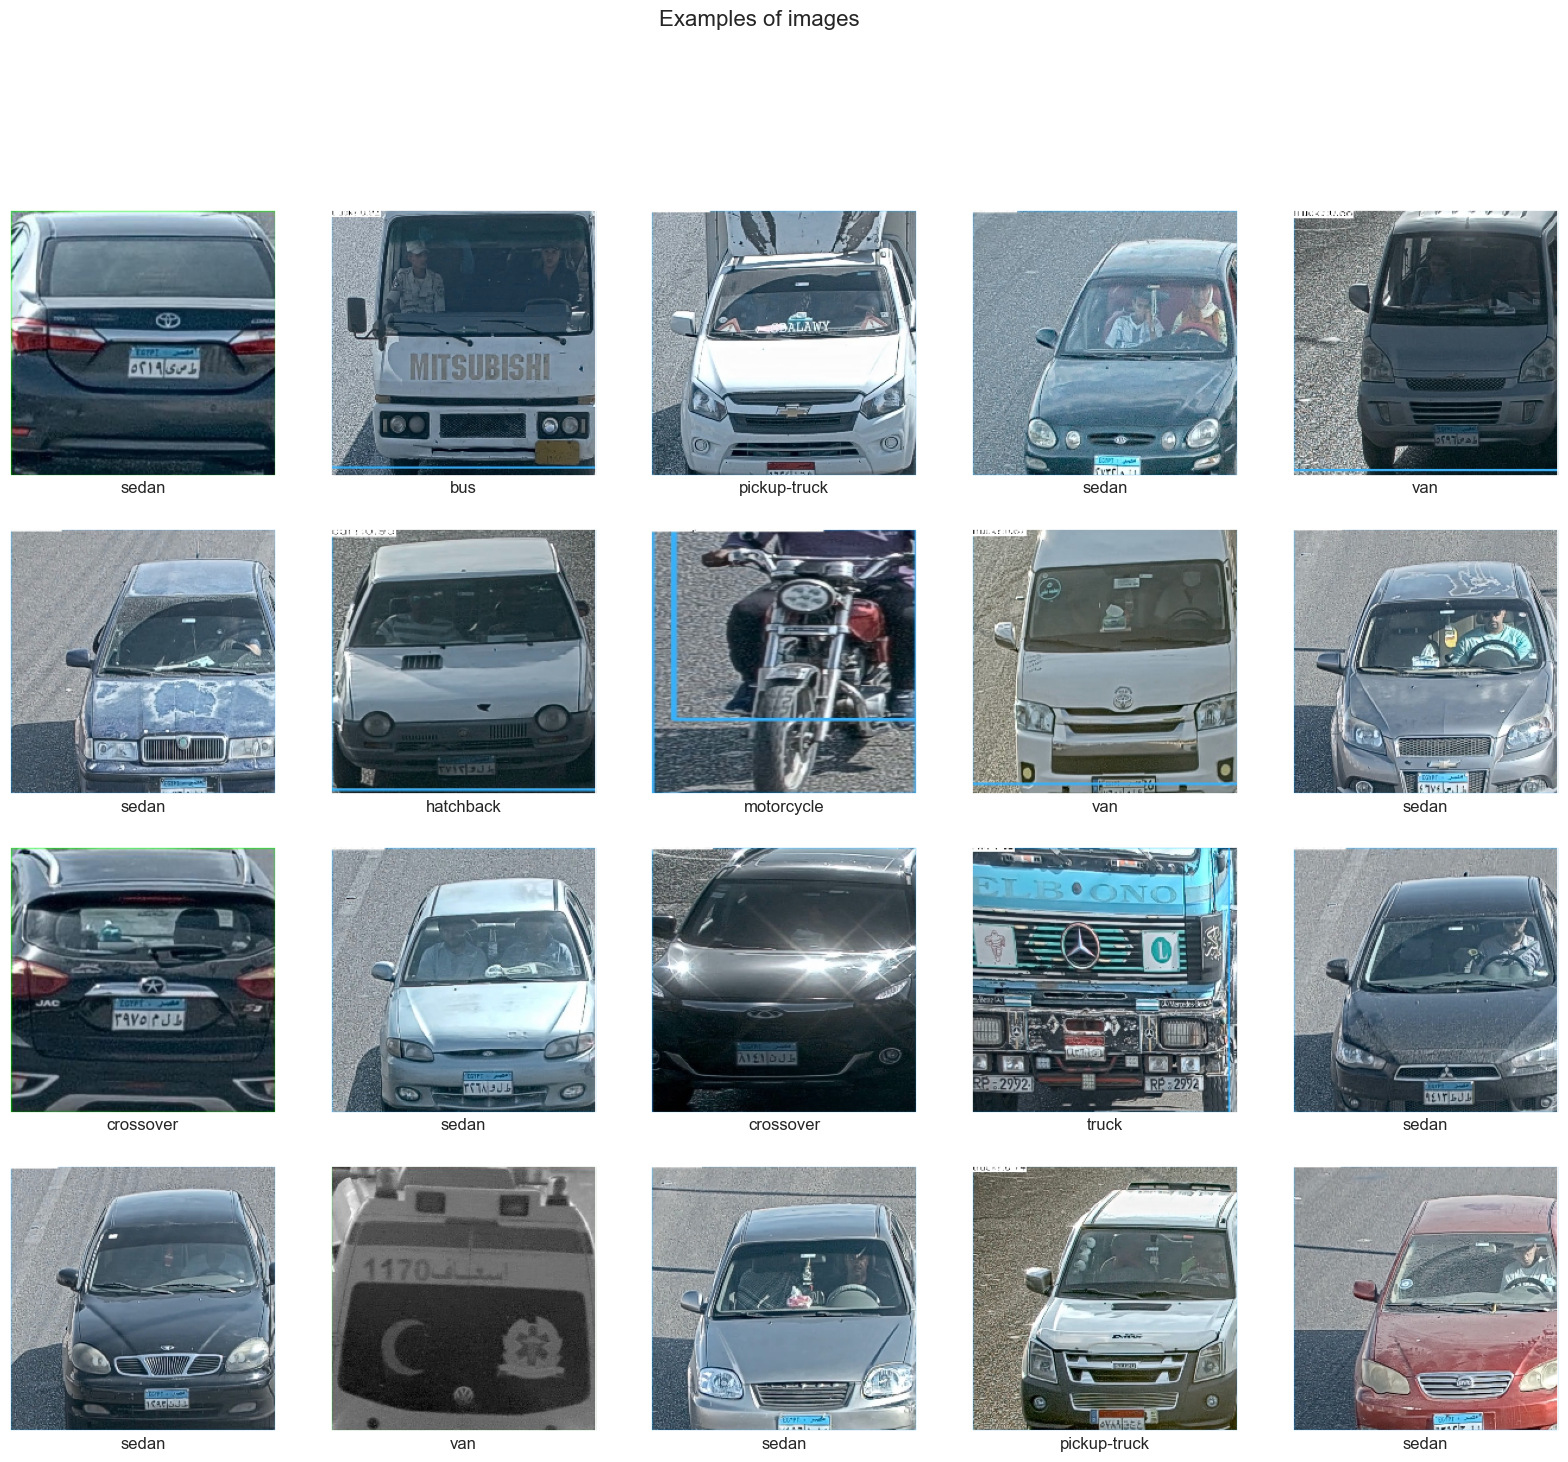

In [140]:
def display_exmaples(class_names,images,labels,Number_images=20):
    
    figsize =(20,20)
    fig = plt.figure(figsize=figsize)
    fig.suptitle("Examples of images",fontsize=16)
    for i in range(Number_images):
        plt.subplot(math.ceil(Number_images/4),math.ceil(Number_images/4),i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
#         image = cv2.resize(images[i],figsize)
        plt.imshow(images[i])
        plt.xlabel(class_names[labels[i]])
    plt.show()

display_exmaples(class_names,train_images , train_labels)
    
    
    

In [141]:
K.clear_session()

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation='relu',input_shape=(224, 224,3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512,activation=tf.nn.relu),
    tf.keras.layers.Dense(256,activation=tf.nn.relu),
    tf.keras.layers.Dense(128,activation=tf.nn.relu),
    tf.keras.layers.Dense(8,activation=tf.nn.softmax)
])

In [142]:
model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [143]:
history = model.fit(train_images,train_labels,validation_split=0.2,
                    batch_size= 128,epochs = 10,verbose=1)

Epoch 1/10
24/24 [==============================] - 36s 1s/step - loss: 2.4159 - accuracy: 0.4009 - val_loss: 1.6544 - val_accuracy: 0.4342
Epoch 2/10
24/24 [==============================] - 31s 1s/step - loss: 1.4043 - accuracy: 0.5098 - val_loss: 1.2356 - val_accuracy: 0.5387
Epoch 3/10
24/24 [==============================] - 31s 1s/step - loss: 0.9797 - accuracy: 0.6608 - val_loss: 1.0810 - val_accuracy: 0.6038
Epoch 4/10
24/24 [==============================] - 31s 1s/step - loss: 0.7219 - accuracy: 0.7422 - val_loss: 1.0054 - val_accuracy: 0.6323
Epoch 5/10
24/24 [==============================] - 31s 1s/step - loss: 0.4504 - accuracy: 0.8440 - val_loss: 0.8794 - val_accuracy: 0.6852
Epoch 6/10
24/24 [==============================] - 32s 1s/step - loss: 0.3147 - accuracy: 0.8911 - val_loss: 0.9685 - val_accuracy: 0.7056
Epoch 7/10
24/24 [==============================] - 31s 1s/step - loss: 0.2993 - accuracy: 0.8931 - val_loss: 0.8804 - val_accuracy: 0.7110
Epoch 8/10
24/24 [==

## Evalution

###  Plot Performance

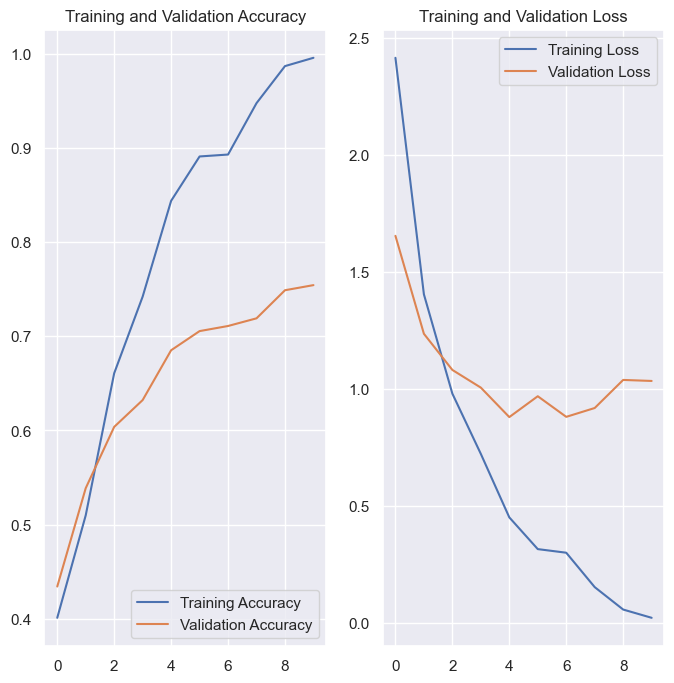

In [145]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(10)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [146]:
test_loss = model.evaluate(test_images,test_labels)

29/29 [==============================] - 3s 93ms/step - loss: 1.4399 - accuracy: 0.6826


In [148]:
len(test_images)

923

In [147]:
test_images

array([[[[0.9960785 , 0.9960785 , 0.9960785 ],
         [1.        , 1.        , 1.        ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         ...,
         [0.5019608 , 0.5686275 , 0.6       ],
         [0.50980395, 0.5764706 , 0.60784316],
         [0.5137255 , 0.5803922 , 0.6117647 ]],

        [[0.9960785 , 0.9960785 , 0.9960785 ],
         [0.08627451, 0.08627451, 0.08627451],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         ...,
         [0.5058824 , 0.57254905, 0.6039216 ],
         [0.5058824 , 0.57254905, 0.6039216 ],
         [0.4901961 , 0.5568628 , 0.5882353 ]],

        [[0.34117648, 0.34117648, 0.34117648],
         [1.        , 1.        , 1.        ],
         [0.9960785 , 0.9960785 , 0.9960785 ],
         ...,
         [0.5058824 , 0.57254905, 0.6039216 ],
         [0.5019608 , 0.5686275 , 0.6       ],
         [0.49411768, 0.5568628 , 0.5882353 ]],

        ...,

        [[0.3372549 , 0.42352945, 0.47450984],
         [0.2901961 , 0.37647063, 0.427451  ]

In [149]:
y_hat = model.predict(test_images)
pred_lables = np.argmax(y_hat,axis = 1)

29/29 [==============================] - 3s 84ms/step


In [150]:
print(classification_report(test_labels,pred_lables))

              precision    recall  f1-score   support

           0       0.50      0.25      0.33        20
           1       0.67      0.48      0.56       120
           2       0.41      0.60      0.49       105
           3       1.00      0.95      0.98        22
           4       0.55      0.68      0.61        90
           5       0.85      0.81      0.83       396
           6       0.50      0.60      0.55        65
           7       0.73      0.59      0.65       105

    accuracy                           0.68       923
   macro avg       0.65      0.62      0.62       923
weighted avg       0.70      0.68      0.69       923



In [151]:
new_dict = {value:key for (key,value) in class_name_label.items()}
new_dict

{0: 'bus',
 1: 'crossover',
 2: 'hatchback',
 3: 'motorcycle',
 4: 'pickup-truck',
 5: 'sedan',
 6: 'truck',
 7: 'van'}

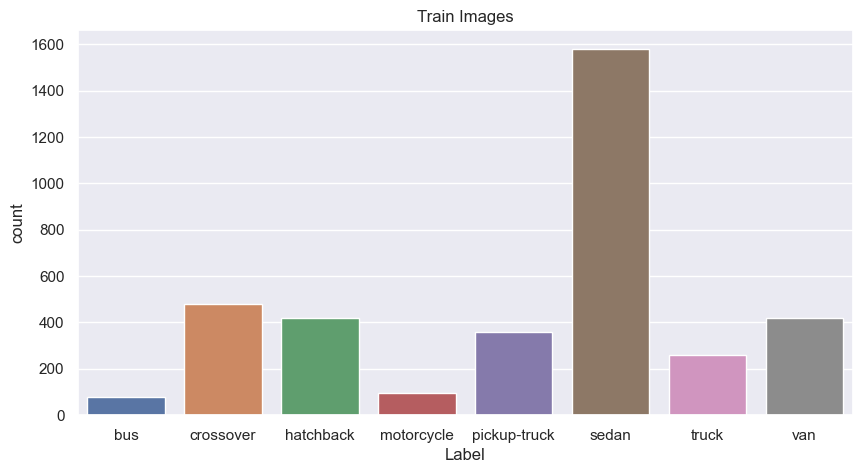

In [159]:
new_dict.values()

dict_values(['bus', 'crossover', 'hatchback', 'motorcycle', 'pickup-truck', 'sedan', 'truck', 'van'])

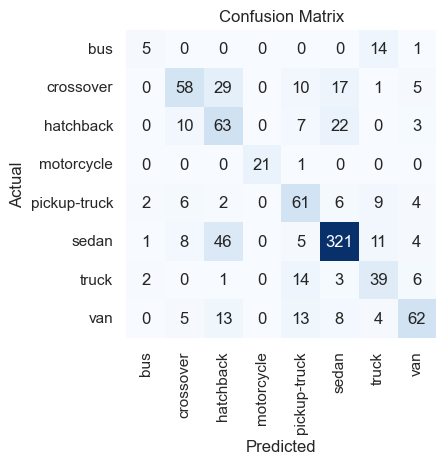

In [160]:
classes = 8
length=classes

x_axis_labels = new_dict.values() # labels for x-axis
y_axis_labels = new_dict.values() # labels for y-axis


fig_width= int(length * .5)
fig_height= int(length * .5)

cm = confusion_matrix(test_labels,pred_lables )
plt.figure(figsize=(fig_width, fig_height))
 
sns.heatmap(cm, annot=True,xticklabels=x_axis_labels, yticklabels=y_axis_labels, vmin=0, fmt='g', cmap='Blues', cbar=False)       

# plt.xticks(np.arange(length)+.5, classes, rotation= 90)

# plt.yticks(np.arange(length)+.5, classes, rotation=0)

plt.xlabel("Predicted")

plt.ylabel("Actual")

plt.title("Confusion Matrix")

plt.show()

## Save Model

In [161]:
from tensorflow.keras.models import load_model

In [162]:
model.save(os.path.join('models','Cars_CNN.h5'))

In [163]:
new_model = load_model(os.path.join('models','Cars_CNN.h5'))

In [164]:
new_model

In [180]:
img_path = 'D:\Work\AIactive\sedan.jpg'  # image online
#open and resize img
image = cv2.imread(img_path)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
image = cv2.resize(image,Image_size)
image = Rescaling(1./255)(image)        
image_test = np.array(image,dtype='float32')
print(image_test.shape)
y_hat_t = new_model.predict(np.expand_dims(image_test,0))
print(y_hat_t)
pred_lables = np.argmax(y_hat_t,axis = 1)
classes = list(new_dict.values())
print('pred_lables',pred_lables,'is',classes[pred_lables[0]])
# print(classes[pred_lables[0]])


(224, 224, 3)
1/1 [==============================] - 0s 26ms/step
[[1.3056308e-02 1.4749880e-11 2.0755076e-07 4.7859654e-08 1.2302092e-01
  8.6347806e-01 2.1486452e-05 4.2301792e-04]]
pred_lables [5] is sedan
